In [ ]:
# Conexão do Google Drive
from google.colab import drive
drive.mount('/content/drive')

!pip install rasterio

import os
import numpy as np
import pandas as pd
import rasterio
import shap
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from rasterio.enums import Resampling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from skimage import io

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# 📌 Novas pastas para salvar o modelo e logs
pasta_patches = "/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32"
pasta_checkpoint = "/content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4"
pasta_logs = "/content/drive/MyDrive/Unb/Autoencoder_Logs_4"
pasta_clusters = "/content/drive/MyDrive/Unb/Cluster_Results"

# Criar diretórios, se não existirem
os.makedirs(pasta_checkpoint, exist_ok=True)
os.makedirs(pasta_logs, exist_ok=True)
os.makedirs(pasta_clusters, exist_ok=True)

# 🔹 Hiperparâmetros
IMG_SIZE = 32
NUM_BANDS = 16
LATENT_DIM = 128
BATCH_SIZE = 32
EPOCHS = 13
N_CLUSTERS = 5  # Número de clusters para classificação das imagens

# 🔹 Normalizador global para os patches
scaler = MinMaxScaler()

# 🔹 Função para carregar e normalizar imagens TIFF
def carregar_patches(arquivos_tiff):
    imagens, nomes_arquivos = [], []

    for arquivo in arquivos_tiff:
        with rasterio.open(arquivo) as dataset:
            img = dataset.read(out_shape=(NUM_BANDS, IMG_SIZE, IMG_SIZE), resampling=Resampling.bilinear)
            img = img.astype(np.float32)
            img = np.transpose(img, (1, 2, 0))  # (32,32,16)

            # 🔹 Normalizar valores (MinMaxScaler)
            img = img.reshape(-1, NUM_BANDS)
            img = scaler.fit_transform(img)  # Normalizar entre 0 e 1
            img = img.reshape(IMG_SIZE, IMG_SIZE, NUM_BANDS)

            imagens.append(img)
            nomes_arquivos.append(os.path.basename(arquivo))

    return np.array(imagens), nomes_arquivos

# 🔹 Carregar imagens e dividir em treino/teste
arquivos_tiff = [os.path.join(pasta_patches, f) for f in os.listdir(pasta_patches) if f.endswith(".tif")]
imagens, nomes_arquivos = carregar_patches(arquivos_tiff)
X_train, X_test = train_test_split(imagens, test_size=0.2, random_state=42)

# 🔹 Criar o Autoencoder ajustado
def criar_autoencoder():
    input_img = keras.Input(shape=(IMG_SIZE, IMG_SIZE, NUM_BANDS))

    # 🔹 Encoder
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)

    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.2)(x)

    encoded = layers.Flatten()(x)
    encoded = layers.Dense(LATENT_DIM, activation='relu', name="latent_layer")(encoded)  # 🔹 Camada latente

    # 🔹 Decoder
    x = layers.Dense(8 * 8 * 128, activation='relu')(encoded)
    x = layers.Reshape((8, 8, 128))(x)

    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)

    decoded = layers.Conv2D(NUM_BANDS, (3, 3), activation='linear', padding='same')(x)

    autoencoder = keras.Model(input_img, decoded)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005), loss='mse')

    # 🔹 Criar modelo do encoder separadamente
    encoder = Model(inputs=input_img, outputs=encoded)

    return autoencoder, encoder

# 🔹 Criar modelos
autoencoder, encoder = criar_autoencoder()

# 🔹 Callbacks
checkpoint_path = os.path.join(pasta_checkpoint, "autoencoder_best.h5")
csv_logger_path = os.path.join(pasta_logs, "training_log.csv")

checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True, verbose=1)
csv_logger = CSVLogger(csv_logger_path, append=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# 🔹 Treinar o modelo
history = autoencoder.fit(
    X_train, X_train,
    validation_data=(X_test, X_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[checkpoint, csv_logger, reduce_lr]
)

# 🔹 Salvar logs do treinamento
df_logs = pd.read_csv(csv_logger_path)
print(df_logs.tail())

# 🔹 Salvar modelos finais
autoencoder.save(os.path.join(pasta_checkpoint, "autoencoder_final.h5"))
encoder.save(os.path.join(pasta_checkpoint, "encoder_final.h5"))

# 🔹 Extração da Representação Latente
latents = encoder.predict(imagens)

# 🔹 Aplicação do K-Means para identificar clusters
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42)
labels = kmeans.fit_predict(latents)

# 🔹 Criar um DataFrame com os rótulos
df_clusters = pd.DataFrame({"Arquivo": nomes_arquivos, "Cluster": labels})
df_clusters.to_csv(os.path.join(pasta_clusters, "clusters.csv"), index=False)

print(f"✅ Clusterização concluída! Resultados salvos em {pasta_clusters}/clusters.csv")

Epoch 1/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - loss: 0.2122
Epoch 1: val_loss improved from inf to 0.23414, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - loss: 0.2090 - val_loss: 0.2341 - learning_rate: 5.0000e-04
Epoch 2/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0697
Epoch 2: val_loss improved from 0.23414 to 0.20198, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 145ms/step - loss: 0.0695 - val_loss: 0.2020 - learning_rate: 5.0000e-04
Epoch 3/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - loss: 0.0555
Epoch 3: val_loss improved from 0.20198 to 0.16259, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.0553 - val_loss: 0.1626 - learning_rate: 5.0000e-04
Epoch 4/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0460
Epoch 4: val_loss improved from 0.16259 to 0.14010, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 200ms/step - loss: 0.0459 - val_loss: 0.1401 - learning_rate: 5.0000e-04
Epoch 5/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0381
Epoch 5: val_loss improved from 0.14010 to 0.12454, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 147ms/step - loss: 0.0380 - val_loss: 0.1245 - learning_rate: 5.0000e-04
Epoch 6/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0332
Epoch 6: val_loss improved from 0.12454 to 0.11487, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.0331 - val_loss: 0.1149 - learning_rate: 5.0000e-04
Epoch 7/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0297
Epoch 7: val_loss improved from 0.11487 to 0.09063, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 158ms/step - loss: 0.0297 - val_loss: 0.0906 - learning_rate: 5.0000e-04
Epoch 8/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0292
Epoch 8: val_loss improved from 0.09063 to 0.07799, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - loss: 0.0292 - val_loss: 0.0780 - learning_rate: 5.0000e-04
Epoch 9/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - loss: 0.0277
Epoch 9: val_loss did not improve from 0.07799
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 142ms/step - loss: 0.0277 - val_loss: 0.0788 - learning_rate: 5.0000e-04
Epoch 10/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0263
Epoch 10: val_loss improved from 0.07799 to 0.06897, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - loss: 0.0263 - val_loss: 0.0690 - learning_rate: 5.0000e-04
Epoch 11/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0244
Epoch 11: val_loss improved from 0.06897 to 0.06843, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0244 - val_loss: 0.0684 - learning_rate: 5.0000e-04
Epoch 12/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0239
Epoch 12: val_loss improved from 0.06843 to 0.05919, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - loss: 0.0239 - val_loss: 0.0592 - learning_rate: 5.0000e-04
Epoch 13/13
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - loss: 0.0230
Epoch 13: val_loss improved from 0.05919 to 0.05460, saving model to /content/drive/MyDrive/Unb/Autoencoder_Checkpoints_4/autoencoder_best.h5


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - loss: 0.0230 - val_loss: 0.0546 - learning_rate: 5.0000e-04


     epoch      loss  val_loss
99       8  0.027300  0.078775
100      9  0.025940  0.068966
101     10  0.024671  0.068425
102     11  0.023930  0.059189
103     12  0.023124  0.054595


23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
✅ Clusterização concluída! Resultados salvos em /content/drive/MyDrive/Unb/Cluster_Results/clusters.csv


In [ ]:
df_clusters["Cluster"].value_counts()

,count
Cluster,
2,171
4,158
1,155
3,115
0,109


In [ ]:
df_clusters.head()

,Arquivo,Cluster
0,patch_0.tif,2
1,patch_1.tif,2
2,patch_4.tif,2
3,patch_6.tif,4
4,patch_2.tif,2


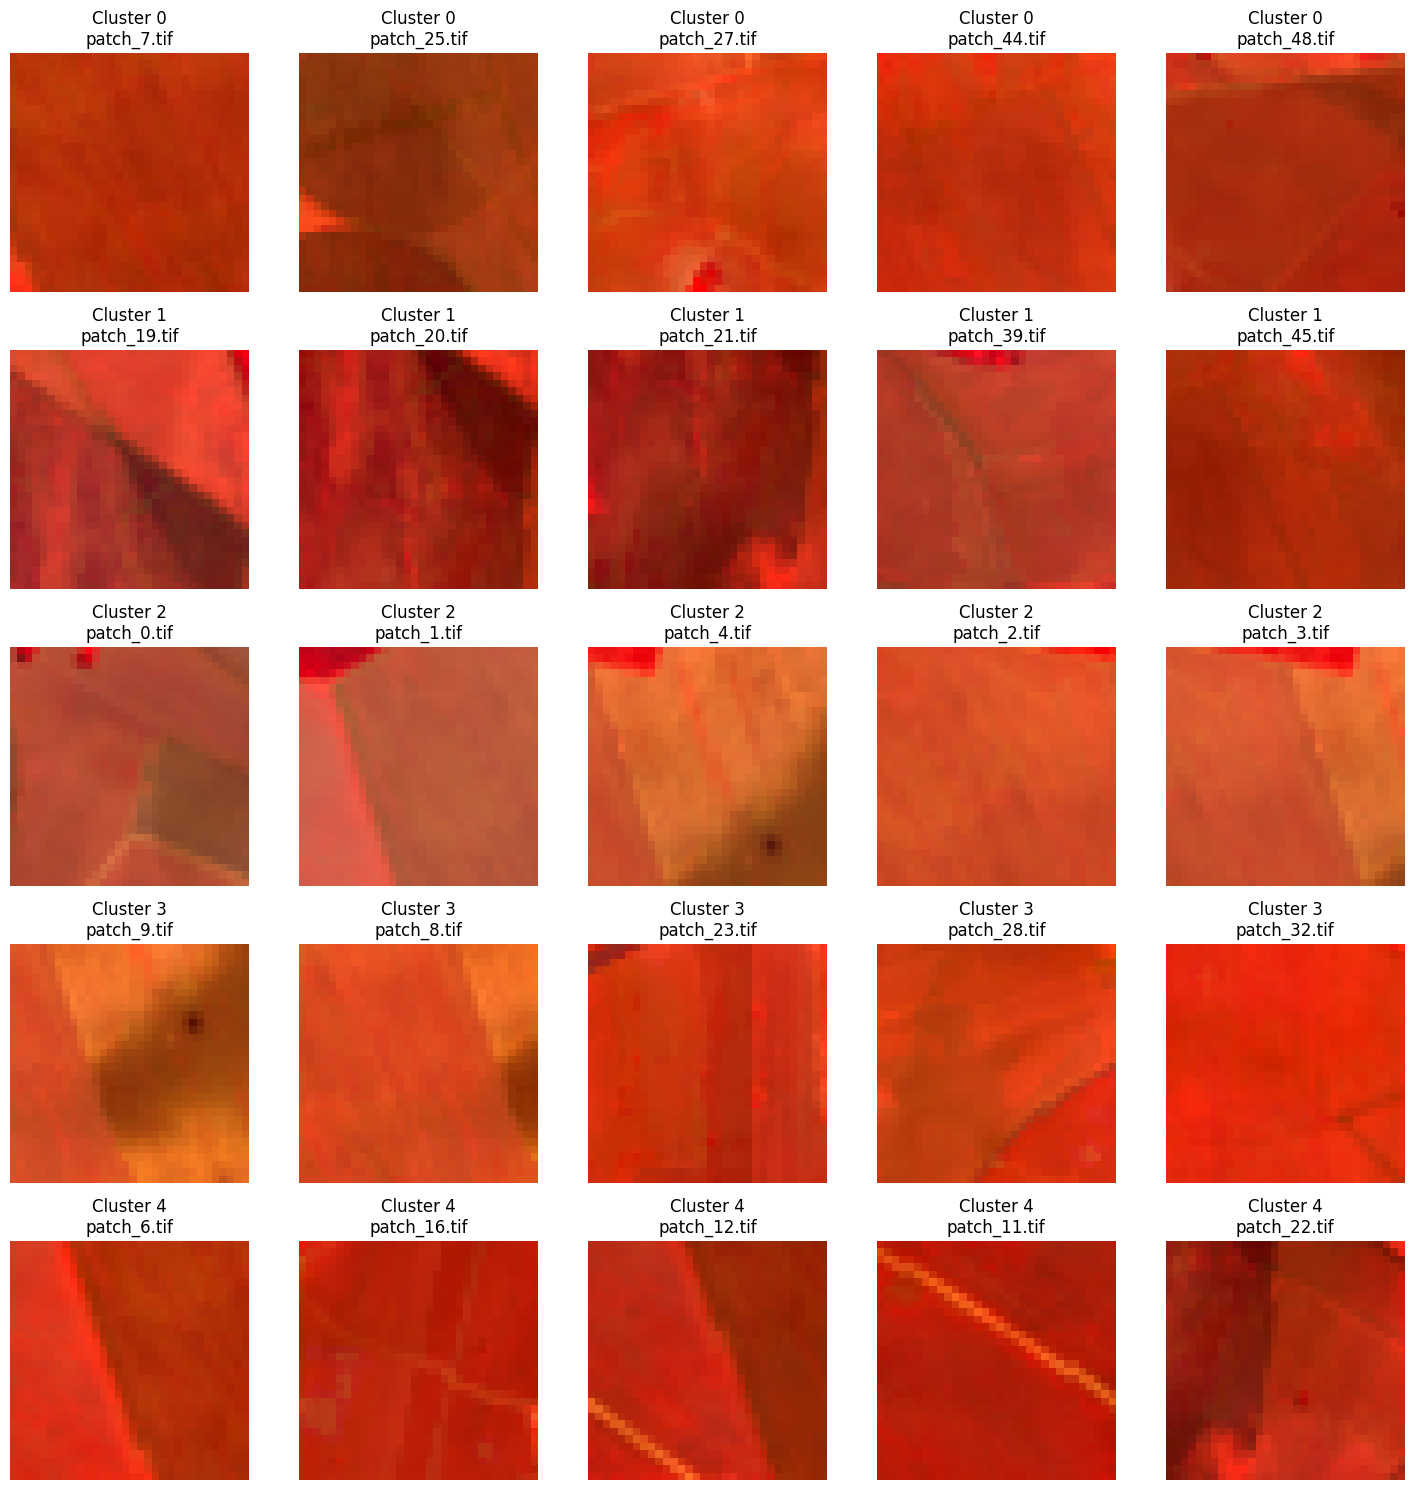

In [ ]:
def exibir_cluster(df_clusters, norm = 1, caminho_base = '/content/drive/MyDrive/Unb/Plantio_direto/Patches_32x32', n_imagens=5, bandas_rgb=[4, 3, 2]):
    """
    Exibe n_imagens RGB de cada cluster, selecionando bandas específicas.

    Parâmetros:
        df_clusters (pd.DataFrame): DataFrame com as colunas 'Arquivo' e 'Cluster'.
        caminho_base (str): Caminho base onde as imagens estão armazenadas.
        n_imagens (int): Número de imagens a serem exibidas por cluster.
        bandas_rgb (list): Lista com os índices das 3 bandas a serem usadas como RGB.
    """
    # Verificar clusters únicos
    clusters = df_clusters['Cluster'].unique()
    clusters.sort()

    # Configurar a figura
    fig, axes = plt.subplots(len(clusters), n_imagens, figsize=(15, 3 * len(clusters)))
    fig.subplots_adjust(hspace=0.4, wspace=0.1)

    # Iterar sobre cada cluster
    for i, cluster in enumerate(clusters):
        # Filtrar imagens do cluster atual
        imagens_cluster = df_clusters[df_clusters['Cluster'] == cluster]['Arquivo'].values[:n_imagens]

        # Exibir as imagens do cluster
        for j, arquivo in enumerate(imagens_cluster):
            # Caminho completo da imagem
            caminho_imagem = os.path.join(caminho_base, arquivo)

            # Carregar a imagem (16 bandas)
            imagem = io.imread(caminho_imagem)  # Formato (32, 32, 16)

            # Selecionar as bandas RGB
            imagem_rgb = imagem[:, :, bandas_rgb]

            # # Normalizar os valores para o intervalo [0, 1]
            if norm == 1:
                imagem_rgb = (imagem_rgb - np.min(imagem_rgb)) / (np.max(imagem_rgb) - np.min(imagem_rgb))

            # Exibir a imagem
            ax = axes[i, j]
            ax.imshow(imagem_rgb)
            ax.axis('off')
            ax.set_title(f'Cluster {cluster}\n{arquivo}')

    # Ajustar layout e mostrar a figura
    plt.tight_layout()
    plt.show()

exibir_cluster(df_clusters, norm=1)

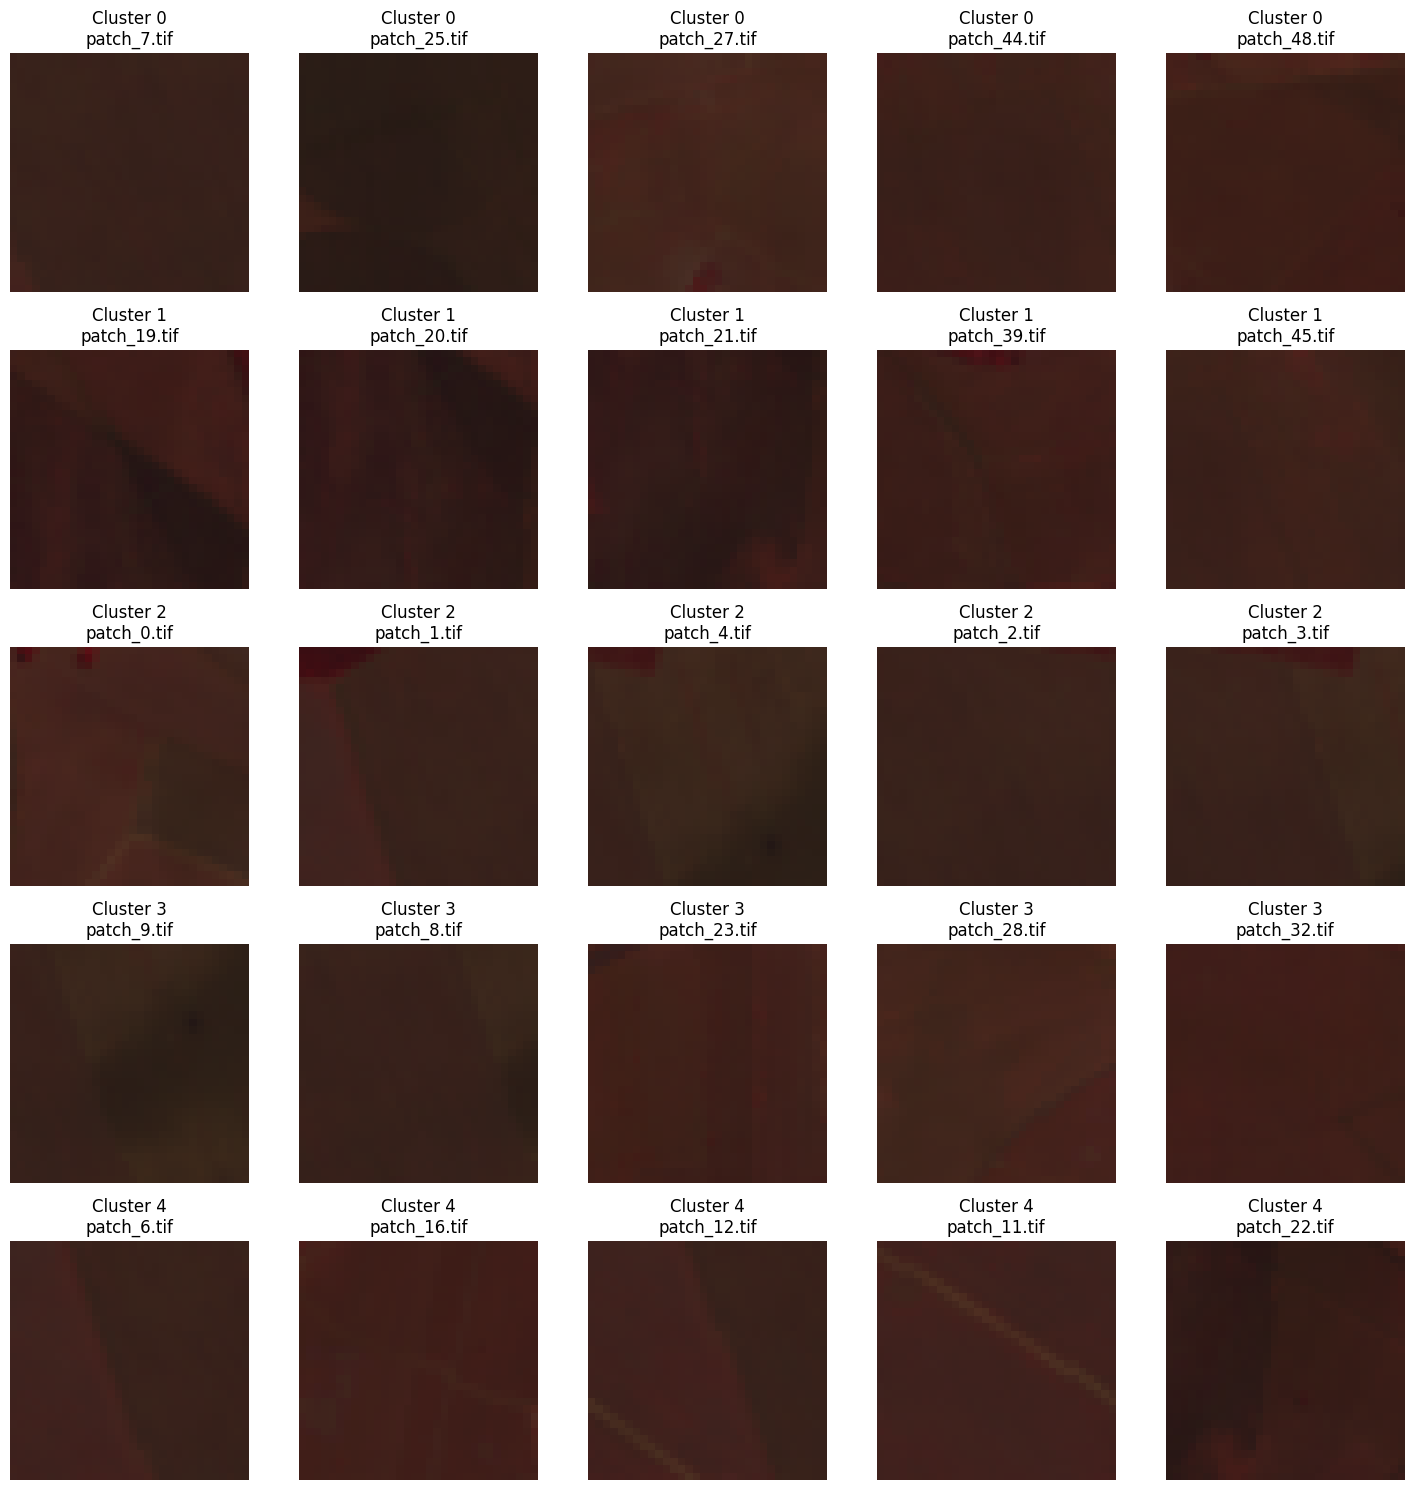

In [ ]:

exibir_cluster(df_clusters, norm=0)
